In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import time
import re
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.models as models
from multiprocessing import dummy as mp
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from wideresnet import WideResNet
from utils import *
from simclr_utils import *
from auto_tqdm import tqdm
import augmentations
%matplotlib inline

DATA_DIR = '/data/amiratag/prostate'
MEM_DIR = '/data/amiratag/Projects/sslp'

## Functions

In [2]:
def train(device, model, train_loader, optimizer, epoch):
    
    model.train()
    train_metrics = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        train_metrics.append(dict(
            epoch=epoch,
            loss=loss.item()))
        if batch_idx % 10 == 9:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader) * args.batch_size,
                           100. * batch_idx / len(train_loader), loss.item()))
            
    if epoch % args.save_freq == 0 or epoch == args.epochs:
        torch.save(dict(
                        state_dict=model.state_dict()),
                   os.path.join(args.model_dir,
                                'checkpoint-epoch{}.pt'.format(epoch)))
        torch.save(optimizer.state_dict(),
                   os.path.join(args.model_dir,
                                'opt-checkpoint_epoch{}.tar'.format(epoch)))
        
    delete_old_ckpts(args.model_dir)
    return train_metrics

## Arguments

In [3]:
parser = argparse.ArgumentParser(
    description='PyTorch TRADES Adversarial Training')

parser.add_argument('--seed', type=int, default=1,
                    help='Random seed. '
                         'Note: fixing the random seed does not give complete '
                         'reproducibility. See '
                         'https://pytorch.org/docs/stable/notes/randomness.html')
parser.add_argument('--model_dir', default='./simclr/originalrotate',
                    help='Directory of model for saving checkpoint')
parser.add_argument('--overwrite', action='store_true', default=False,
                    help='Cancels the run if an appropriate checkpoint is found')
parser.add_argument('--batch_size', type=int, default=24, metavar='N',
                    help='Input batch size for training (default: 128)')
parser.add_argument('--embedding_batch_size', type=int, default=320, metavar='N',
                    help='Input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='Number of epochs to train. '
                         'Note: we arbitrarily define an epoch as a pass '
                         'through 50K datapoints. This is convenient for '
                         'comparison with standard CIFAR-10 training '
                         'configurations.')
parser.add_argument('--eval_freq', default=5, type=int,
                    help='Eval frequency (in epochs)')
parser.add_argument('--save_freq', default=5, type=int,
                    help='Checkpointing frequency (in epochs)')
parser.add_argument('--weight_decay', '--wd', default=5e-4, type=float)
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='Learning rate')
parser.add_argument('--lr_schedule', type=str, default='cosine',
                    choices=('trades', 'trades_fixed', 'cosine', 'wrn'),
                    help='Learning rate schedule')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum')
parser.add_argument('--nesterov', action='store_true', default=True,
                    help='Use extragrdient steps')
parser.add_argument('--out_dim', type=int, default=128,
                    help='Feature dimensionality')
args = parser.parse_args('')
experiment_dir = os.path.join(MEM_DIR, args.model_dir.split('/')[-1])
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

## Load prostate dataset

In [4]:
dataset = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
valid_idxs = np.array([i for i in range(len(dataset)) if dataset['data_provider'][i] == 'radboud' and
                       os.path.exists(os.path.join(DATA_DIR, 'train_images', dataset['image_id'][i])+'.tiff')])
train_idxs = valid_idxs[:-1000]
test_idxs = valid_idxs[-1000:]

train_slides = dataset['image_id'][train_idxs].values
train_isup_dic = dict(zip(train_slides, dataset['isup_grade'][train_idxs]))
test_slides = dataset['image_id'][test_idxs].values
test_isup_dic = dict(zip(test_slides, dataset['isup_grade'][test_idxs]))

## Load slide representations

In [5]:
X, y = [], []
for image_name in train_slides:
    pm_path = os.path.join(experiment_dir, 'train', image_name+'.npy')
    if os.path.exists(pm_path):
        X.append(pm_path)
        y.append(train_isup_dic[image_name])
X_test, y_test = [], []
for image_name in test_slides:
    pm_path = os.path.join(experiment_dir, 'test', image_name+'.npy')
    if os.path.exists(pm_path):
        X_test.append(pm_path)
        y_test.append(test_isup_dic[image_name])
X, y, X_test, y_test = np.array(X), np.array(y), np.array(X_test), np.array(y_test)

## Train ConvNet model

Here, we transform each slide into a 224x224x128 tensor and then train a ConvNet model on top of them for slide-level prediction.

In [6]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device('cuda') if use_cuda else 'cpu'

In [7]:
model = WideResNet(in_channels=128, depth=16, num_classes=6, widen_factor=8)
train_dataset = SlideLevelDataset(X, y)
test_dataset = SlideLevelDataset(X_test, y_test)
kwargs = {'num_workers': 12, 'pin_memory': False} if use_cuda else {}
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader =  DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

In [8]:
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum,
                      weight_decay=args.weight_decay,
                      nesterov=args.nesterov)

checkpoints = [i for i in os.listdir(experiment_dir) if '.pt' in i]
checkpoints_epoch_num = [int(re.search('epoch(\d+)', c).group(1)) for c in checkpoints]
if len(checkpoints_epoch_num):
    init_epoch = np.max(checkpoints_epoch_num)
    checkpoint = torch.load(os.path.join(experiment_dir, 'checkpoint-epoch{}.pt'.format(init_epoch)))
    model.load_state_dict(checkpoint.get('state_dict', checkpoint))
    opt_checkpoint = torch.load(os.path.join(experiment_dir, 'opt-checkpoint_epoch{}.tar'.format(init_epoch)))
    optimizer.load_state_dict(opt_checkpoint)
    logger.info('Loading checkpoint from epoch #{}'.format(init_epoch))
else:
    print('No checkpoint found. Random initialization!')

No checkpoint found. Random initialization!


In [10]:
for epoch in range(1, args.epochs+1):
    t_init = time.time()
    if epoch % args.eval_freq == 0:
        model.eval()
        true, predicted = [], []
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            predicted.append(logits.argmax(-1).detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
        print(np.mean(np.concatenate(predicted) == np.concatenate(true)))
    
    lr = adjust_learning_rate(args, optimizer, epoch)
    train(device, model, train_loader, optimizer, epoch)
    if epoch % args.save_freq == 0 or epoch == args.epochs:
        torch.save(dict(
                        state_dict=model.state_dict()),
                   os.path.join(experiment_dir,
                                'checkpoint-epoch{}.pt'.format(epoch)))
        torch.save(optimizer.state_dict(),
                   os.path.join(experiment_dir,
                                'opt-checkpoint_epoch{}.tar'.format(epoch)))
        
    delete_old_ckpts(experiment_dir, num_save=1)
    print(time.time() - t_init)

In [ ]:
predictions = []
for _ in range(15):
    model.eval()
    true, predicted = [], []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        predicted.append(logits.argmax(-1).detach().cpu().numpy())
        true.append(target.detach().cpu().numpy())
    print(np.mean(np.concatenate(predicted) == np.concatenate(true)))
    predictions.append(np.concatenate(predicted))
predictions = np.stack(predictions, -1)
true = np.concatenate(true)

In [ ]:
counts = np.sum(np.equal(np.expand_dims(predictions[:, :100], -1), np.arange(6).reshape((1, 1, -1))), 1)
predicted = np.argmax(counts, -1)

In [ ]:
fig = plt.figure(figsize=(8, 8))
cm = confusion_matrix(true, predicted)
normalized_cm = cm/np.sum(cm, -1, keepdims=True)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.colorbar()
plt.xticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.yticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Prediction Accuracy = {0:.1f}%'.format(100 * np.mean(true == predicted)), fontsize=15)
for i in range(6):
    for j in range(6):
        plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)

In [ ]:
cohen_kappa_score(true, predicted, weights='quadratic'),\
cohen_kappa_score(true[true > 0], predicted[true > 0], weights='quadratic')

## Clusters

Here, we cluster the SIMCLR model's representation space into ~100 clusters and then on each slide, we assign each tile in it to a cluster. We then translate each slide into a ~100 dimensional vector of cluster frequencies. We then train a simple linear model on top of this representations.

In [7]:
def load_random_tile(slide):
    R = np.load(slide)
    r = R[np.random.choice(R.shape[0]), np.random.choice(R.shape[1])]
    return r.copy()

def compute_slide_assignements(slide, centers):
    output = np.zeros(len(centers))
    R = np.load(slide)
    distances = np.linalg.norm(np.expand_dims(R, 2) - np.expand_dims(np.expand_dims(centers, 0), 1), axis=-1)
    assignments = np.argmin(distances, -1)
    return assignments

def cluster_histogram(slide, centers):
    hist = np.zeros(len(centers))
    assignments = compute_slide_assignements(slide, centers)
    flat = assignments.reshape((len(assignments), -1))
    unique, counts = np.unique(assignments, return_counts=True)
    hist[unique] = counts / np.sum(counts)
    return hist

In [8]:
data_size = 100000

x = []
for i in tqdm(range(data_size)):
    r = load_random_tile(np.random.choice(X))
    x.append(r)
x = np.stack(x, axis=0)
# with mp.Pool(10) as p:
#     x = p.map(lambda s: load_random_tile(s), np.random.choice(X, 100000))
# x = np.stack(x, axis=0)

In [9]:
from sklearn.cluster import KMeans
km = KMeans(128, n_init=5, max_iter=10000, verbose=2)
a = km.fit_predict(x)

Initialization complete
Iteration 0, inertia 963805.25
Iteration 1, inertia 792157.25
Iteration 2, inertia 768885.125
Iteration 3, inertia 758033.8125
Iteration 4, inertia 751577.3125
Iteration 5, inertia 747512.125
Iteration 6, inertia 745002.3125
Iteration 7, inertia 743245.6875
Iteration 8, inertia 741838.375
Iteration 9, inertia 740713.6875
Iteration 10, inertia 739819.625
Iteration 11, inertia 739152.4375
Iteration 12, inertia 738593.8125
Iteration 13, inertia 738150.25
Iteration 14, inertia 737782.875
Iteration 15, inertia 737432.6875
Iteration 16, inertia 737096.75
Iteration 17, inertia 736758.1875
Iteration 18, inertia 736408.9375
Iteration 19, inertia 736109.4375
Iteration 20, inertia 735827.0
Iteration 21, inertia 735577.75
Iteration 22, inertia 735325.5625
Iteration 23, inertia 735141.8125
Iteration 24, inertia 734956.9375
Iteration 25, inertia 734782.9375
Iteration 26, inertia 734626.6875
Iteration 27, inertia 734496.1875
Iteration 28, inertia 734383.5
Iteration 29, inertia

Iteration 46, inertia 732546.4375
Iteration 47, inertia 732493.4375
Iteration 48, inertia 732437.875
Iteration 49, inertia 732361.8125
Iteration 50, inertia 732290.3125
Iteration 51, inertia 732236.0625
Iteration 52, inertia 732205.1875
Iteration 53, inertia 732175.875
Iteration 54, inertia 732154.8125
Iteration 55, inertia 732136.75
Iteration 56, inertia 732121.875
Iteration 57, inertia 732105.0
Iteration 58, inertia 732089.0
Iteration 59, inertia 732076.875
Iteration 60, inertia 732056.875
Iteration 61, inertia 732042.4375
Iteration 62, inertia 732025.3125
Iteration 63, inertia 732004.0
Iteration 64, inertia 731979.4375
Iteration 65, inertia 731951.375
Iteration 66, inertia 731930.375
Iteration 67, inertia 731913.3125
Iteration 68, inertia 731899.1875
Iteration 69, inertia 731889.875
Iteration 70, inertia 731884.625
Iteration 71, inertia 731879.625
Iteration 72, inertia 731875.0
Iteration 73, inertia 731871.3125
Iteration 74, inertia 731860.25
Iteration 75, inertia 731847.0625
Iterat

Iteration 67, inertia 732469.8125
Iteration 68, inertia 732456.0625
Iteration 69, inertia 732441.875
Iteration 70, inertia 732431.3125
Iteration 71, inertia 732422.0625
Iteration 72, inertia 732416.3125
Iteration 73, inertia 732411.25
Iteration 74, inertia 732409.875
Iteration 75, inertia 732409.125
Iteration 76, inertia 732408.8125
Iteration 77, inertia 732408.1875
Iteration 78, inertia 732408.375
Iteration 79, inertia 732408.875
Iteration 80, inertia 732409.3125
Iteration 81, inertia 732409.5625
Iteration 82, inertia 732406.75
Iteration 83, inertia 732407.625
Iteration 84, inertia 732406.375
Iteration 85, inertia 732405.4375
Converged at iteration 85: strict convergence.


(-0.5, 119.5, 26.5, -0.5)

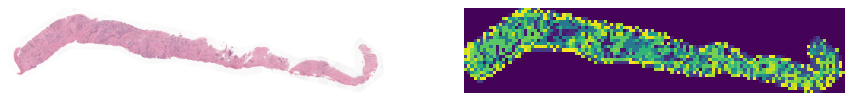

In [10]:
idx = np.random.choice(len(X_test))
image_path = os.path.join(DATA_DIR, 'train_images', X_test[idx].split('/')[-1].replace('.npy', '.tiff'))
m = compute_slide_assignements(X_test[idx], km.cluster_centers_)
slide = io.imread(image_path)
width, height = slide.shape[:2]
fig = plt.figure(figsize=(15, 8 * (slide.shape[0] / slide.shape[1])))
plt.subplot(1, 2, 1)
plt.imshow(Image.fromarray(slide).resize((int(0.1 * slide.shape[1]), int(0.1 * slide.shape[0]))))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(m)
plt.axis('off')

In [125]:
a = np.array([cluster_histogram(i, km.cluster_centers_) for i in tqdm(X)])
a_test = np.array([cluster_histogram(i, km.cluster_centers_) for i in tqdm(X_test)])

In [ ]:
lr = LogisticRegression(C=10, max_iter=1000)
print(cross_val_score(lr, a / np.std(a, 0), y))
lr.fit(a / np.std(a, 0), y)
predicted = lr.predict(a_test / np.std(a, 0))
true = y_test

In [139]:
cohen_kappa_score(true, predicted, weights='quadratic'),\
cohen_kappa_score(true[true > 0], predicted[true > 0], weights='quadratic')

(0.6698222041572233, 0.5311525464178908)

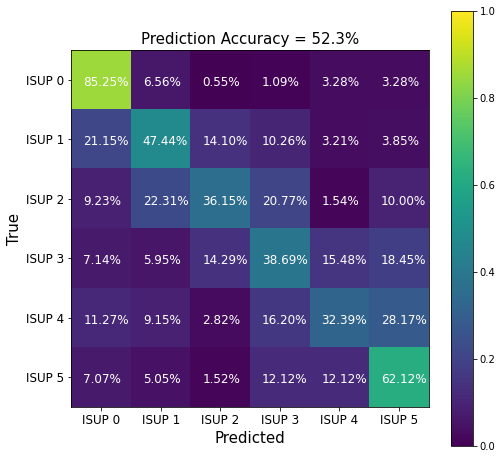

In [134]:
fig = plt.figure(figsize=(8, 8))
cm = confusion_matrix(true, predicted)
normalized_cm = cm/np.sum(cm, -1, keepdims=True)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.colorbar()
plt.xticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.yticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Prediction Accuracy = {0:.1f}%'.format(100 * np.mean(true == predicted)), fontsize=15)
for i in range(6):
    for j in range(6):
        plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)